In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime

from helper import make_alphas_state_matrix_with_day_step
from helper import instrument_return, merge_zeros
from helper import AlphaStats, calc_alphas_corr, std
from helper import normalize, neutralize, neutralize_with_dropout

import manipulate_alpha as mpa

from test import test1, test2, test3
from typing import NamedTuple

SLICE_INDEX = 2436

In [4]:
def decay (alpha_matrix, n): # decrease turnover
    
    factors = (np.arange(1, n + 2)) / (n+1)

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)):
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T
        if not np.array_equal(_alpha, np.zeros_like(_alpha)):
            _new_alpha_states[idx] = _alpha.sum(axis=0)
    
    # return _alpha
    return _new_alpha_states 

In [5]:
def ts_correlation(x, y):
    corr_vec = np.zeros(x.shape[1])

    for idx, (_x, _y) in enumerate(zip(x, y)):
        corr_vec[idx] = calc_alphas_corr(_x, _y)

    return corr_vec

In [6]:
class Alphas_Data(NamedTuple):
    name: str
    cumpnl: np.array

In [179]:
def check_alpha_correlations(alphas, cumpnl_vec):
    for alpha in alphas:
        print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, cumpnl_vec)}')

In [7]:
alphas = []

In [236]:
class Alpha:
    def __init__(self):
        self.alpha = None
        self.zeros = None
        self.pipline = None

    def build_alpha(self):
        pass

# Creat Dataset

In [8]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [9]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

## Mean-reversion alpha

$-ln\frac{open(d)}{close(d-1)}$

In [10]:
day_step = 5

In [11]:
def make_mean_reversion_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(open[day_step:] / close[:-day_step])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [12]:
mean_reversion_alpha = make_mean_reversion_alpha(close_df, open_df, day_step)

# mean_reversion_alpha, zeros_outliers = mpa.CutOutliers(mean_reversion_alpha, 1)
# mean_reversion_alpha, zeros_middles = mpa.CutMiddle(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.truncate_alpha(mean_reversion_alpha, 0.05)
# mean_reversion_alpha = decay(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.crop(mean_reversion_alpha, 0.1)
# zeros_merged = merge_zeros(zeros_outliers, zeros_middles) 

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha,zeros_middles)

mean_reversion_alpha = neutralize(mean_reversion_alpha)
mean_reversion_alpha = normalize(mean_reversion_alpha)

In [13]:
test1(mean_reversion_alpha)
test2(mean_reversion_alpha[day_step:])

Neutrality test passed
Normality test passed


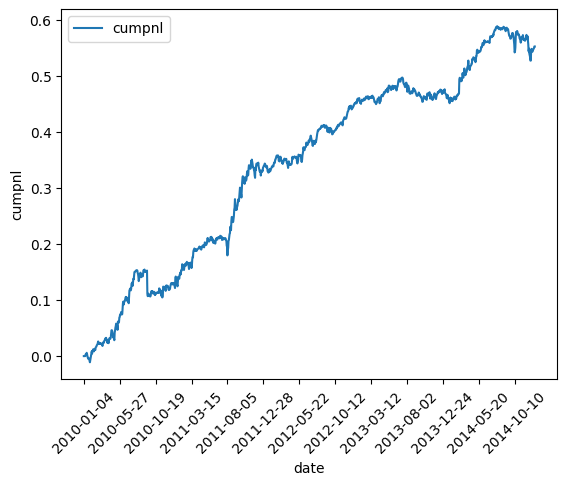

[0.13013280477519074, 0.3397833709379966, 0.4478529330706973, 0.4751585233529981, 0.5534736520708535]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.826766,0.703284,0.049820,0.130133
1,2011,2.661697,0.715459,0.035109,0.339783
2,2012,2.382048,0.712227,0.022373,0.447853
3,2013,0.601442,0.706987,0.043365,0.475159
4,2014,1.197006,0.704996,0.061401,0.553474


In [14]:
mean_rev_alpha_data, mean_rev_alpha_cumpnl = AlphaStats(mean_reversion_alpha, close_df)
mean_rev_alpha_data.head()

In [15]:
test3(mean_rev_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [16]:
alphas.append(Alphas_Data('mean_reverse', mean_rev_alpha_cumpnl))

## Momentum alpha

$ln\frac{close(d-1)}{open(d-1)}$

In [17]:
def make_momentum_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(close[day_step:] / open[day_step:])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [18]:
day_step = 1

momentum_alpha = make_momentum_alpha(close_df, open_df, day_step)
# momentum_alpha, zeros_outliers = mpa.CutOutliers(momentum_alpha, 10)
# momentum_alpha = mpa.truncate_alpha(momentum_alpha, 0.01)
momentum_alpha = decay(momentum_alpha, 10)

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
momentum_alpha = neutralize(momentum_alpha)
momentum_alpha = normalize(momentum_alpha)

In [19]:
test1(momentum_alpha)
test2(momentum_alpha[day_step:])

Neutrality test passed
Normality test passed


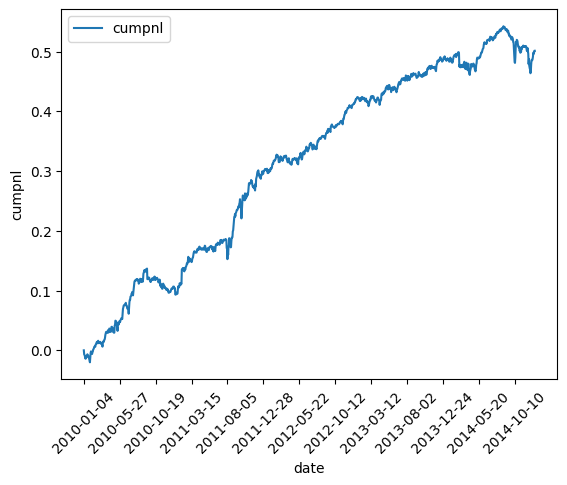

[0.10661293792031856, 0.3002020191697033, 0.41216837396106537, 0.4888151010074261, 0.5013727770371479]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.039785,0.525302,0.040283,0.106613
1,2011,2.744481,0.485311,0.033744,0.300202
2,2012,2.879972,0.477292,0.016937,0.412168
3,2013,1.992797,0.479547,0.015440,0.488815
4,2014,0.199084,0.487745,0.078618,0.501373


In [20]:
momentum_alpha_data, momentum_alpha_cumpnl = AlphaStats(momentum_alpha, close_df)
momentum_alpha_data.head()

In [21]:
test3(momentum_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [180]:
check_alpha_correlations(alphas, momentum_alpha_cumpnl)

mean_reverse:	0.9926339585133639


## Alpha 1

**(rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)**

In [23]:
def make_alpha_1(close_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    return_matrix = instrument_return(close_df)

    alpha = np.zeros((close.shape))

    for i in range(day_step, len(close)):
        alpha[i] += np.where(return_matrix[i] > 0, std(return_matrix[i-day_step:i]), close[i])**2.

    sub_alpha = np.zeros((close.shape))

    for i in range(5, len(alpha)):
        # print(mpa.rank(np.argmax(alpha[i-5:i], axis=0)))
        sub_alpha[i] += np.argmax(alpha[i-5:i], axis=0)# - 0.5

    for i in range(day_step, len(close)):
        alpha[i] = mpa.rank(sub_alpha[i]) - 0.5

    return -alpha

In [24]:
alpha_1 = make_alpha_1(close_df, 20)
# alpha_1, zeros = mpa.CutMiddle(alpha_1, 5)
alpha_1 = mpa.truncate_alpha(alpha_1, 0.03)

In [25]:
# alpha_1 = neutralize_with_dropout(alpha_1, zeros)
alpha_1 = neutralize(alpha_1)
alpha_1 = normalize(alpha_1)

In [26]:
test1(alpha_1)
test2(alpha_1[20:])

Neutrality test passed
Normality test passed


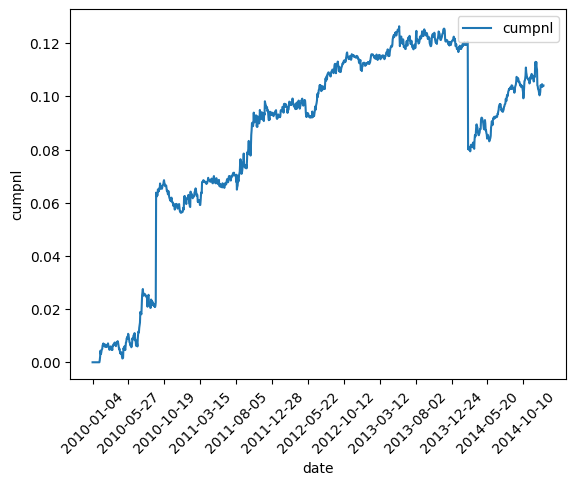

[0.05659399476211514, 0.09343379260853305, 0.11135199820096696, 0.12122458604296424, 0.10410979438241103]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.284688,0.600742,0.012185,0.056594
1,2011,1.562386,0.654827,0.007106,0.093434
2,2012,1.163302,0.639437,0.007223,0.111352
3,2013,0.670318,0.629265,0.008671,0.121225
4,2014,-0.388986,0.643693,0.043141,0.104110


In [27]:
alpha_1_data, alpha_1_cumpnl = AlphaStats(alpha_1, close_df)
alpha_1_data.head()

In [28]:
test3(alpha_1_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [181]:
check_alpha_correlations(alphas, alpha_1_cumpnl)

mean_reverse:	0.8677169672538532


## Alpha2

**(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))**

In [30]:
def make_alpha_2(close_df, open_df, volume_df):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    _alpha = (close - open) / open
    log_vol = np.where(volume != 0, np.log(volume), 0.)
    delta = log_vol[2:] - log_vol[:-2]
    # delta = np.log(volume[2:]) - np.log(volume[:-2])

    sub_alpha = np.zeros_like(_alpha)
    for i in range(len(_alpha)):
        sub_alpha[i] = mpa.rank(_alpha[i])

    sub_delta = np.zeros_like(delta)
    for i in range(len(delta)):
        sub_delta[i] = mpa.rank(delta[i])
    
    alpha = np.zeros_like(delta)
    for i in range(6, len(delta)):
        alpha[i] = -1 * ts_correlation(sub_delta[i-6:i], sub_alpha[2+i-6:2+i])

    return np.concatenate((np.zeros((2, _alpha.shape[1])), alpha))

In [31]:
alpha_2 = make_alpha_2(close_df, open_df, volume_df)

alpha_2 = mpa.truncate_alpha(alpha_2, 35)
# alpha_2, zeros = mpa.CutOutliers(alpha_2, 5)
# alpha_2 = neutralize_with_dropout(alpha_2, zeros)
alpha_2 = neutralize(alpha_2)
alpha_2 = normalize(alpha_2)

test1(alpha_2)
test2(alpha_2[8:])

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_62258/623623427.py:7: RuntimeWarning: divide by zero encountered in log
  log_vol = np.where(volume != 0, np.log(volume), 0.)


Neutrality test passed
Normality test passed


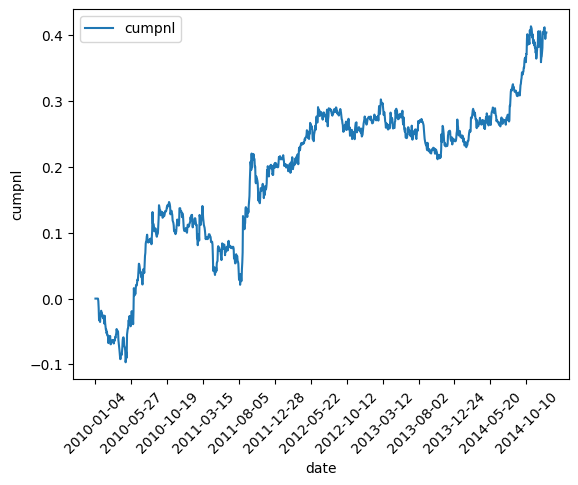

[0.10344481355579625, 0.2060959596678211, 0.2734583987148915, 0.23969840484729088, 0.4043370431567007]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.912552,0.774263,0.096753,0.103445
1,2011,0.742378,0.956714,0.119708,0.206096
2,2012,0.782612,0.838893,0.048731,0.273458
3,2013,-0.384917,0.795023,0.090916,0.239698
4,2014,1.584022,0.882743,0.054556,0.404337


In [32]:
alpha_2_data, alpha_2_cumpnl = AlphaStats(alpha_2, close_df)
alpha_2_data.head()

In [33]:
test3(alpha_2_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test passed
passed 1 out of 3 tests


In [182]:
check_alpha_correlations(alphas, alpha_2_cumpnl)

mean_reverse:	0.9281811977109417


# Alpha 3

**(-1 * correlation(rank(open), rank(volume), 10))**

In [35]:
def make_alpha_3(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    _open = np.zeros_like(open)
    _volume = np.zeros_like(volume)

    for idx, (x, y) in enumerate(zip(open, volume)):
        _open[idx] = mpa.rank(x)
        _volume[idx] = mpa.rank(y)

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(volume)):
        alpha[i] = -1 * ts_correlation(_open[i-day_step: i], _volume[i-day_step: i])

    return alpha

In [36]:
day_step = 10

alpha_3 = - make_alpha_3(open_df, volume_df, day_step)

alpha_3 = mpa.truncate_alpha(alpha_3, 3)

alpha_3 = neutralize(alpha_3)
alpha_3 = normalize(alpha_3)

test1(alpha_2)
test2(alpha_2[day_step:])

Neutrality test passed
Normality test passed


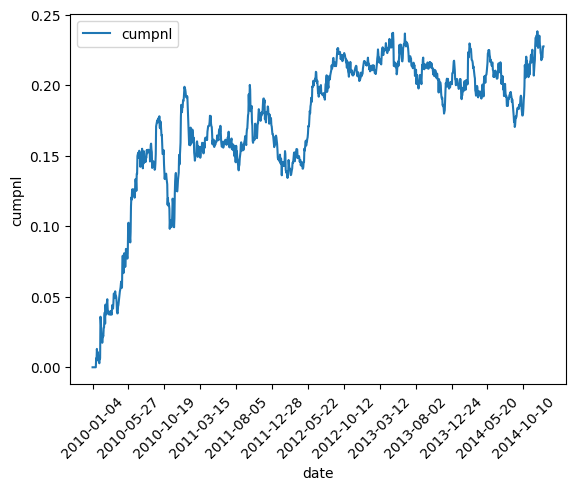

[0.1846421125702086, 0.1653821603838315, 0.20811160221461214, 0.20898418980174527, 0.22768136457576657]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.068841,0.504397,0.079860,0.184642
1,2011,-0.288869,0.444901,0.059282,0.165382
2,2012,0.880658,0.313134,0.031078,0.208112
3,2013,0.016810,0.261934,0.057286,0.208984
4,2014,0.291245,0.308782,0.059249,0.227681


In [37]:
alpha_3_data, alpha_3_cumpnl = AlphaStats(alpha_3, close_df)
alpha_3_data.head()

In [38]:
test3(alpha_3_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [183]:
check_alpha_correlations(alphas, alpha_3_cumpnl)

mean_reverse:	0.8251556642631087


## Alpha 4

**(-1 * Ts_Rank(rank(low), 9))**

In [40]:
def ts_rank(time_series):
    result = np.zeros(time_series.shape[1])

    for i in range(len(result)):
        result[i] = mpa.rank(time_series.T[i])[-1]

    return result

In [41]:
def make_alpha_4(low_df, day_step):
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    low_ranked = np.zeros((low.shape))
    for idx, _low in enumerate(low):
        low_ranked[idx] = mpa.rank(_low)

    alpha = np.zeros_like(low)
    for i in range(day_step, len(low_ranked)):
        alpha[i] = -1 * ts_rank(low_ranked[i-9:i])
        
    # return np.concatenate((np.zeros((day_step, low_ranked.shape[1])), low_ranked[day_step:]))
    return alpha

In [42]:
day_step = 9

alpha_4 = make_alpha_4(low_df, day_step)

alpha_4 = neutralize(alpha_4)
alpha_4 = normalize(alpha_4)

In [43]:
test1(alpha_4)
test2(alpha_4[day_step:])

Neutrality test passed
Normality test passed


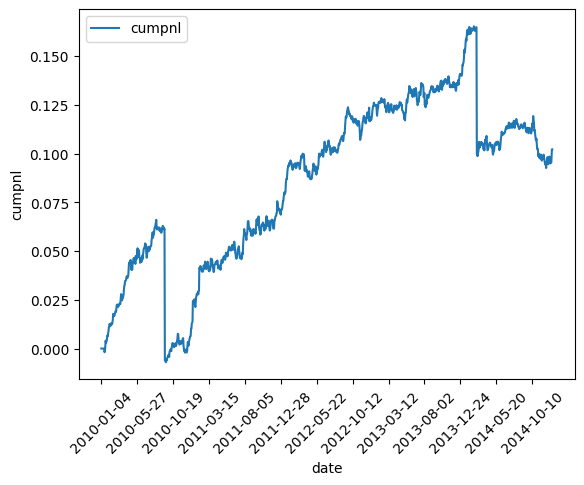

[0.010224528436257839, 0.07126043273881681, 0.11748531086598249, 0.14008944681948576, 0.10228143579833353]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.142697,0.216451,0.073131,0.010225
1,2011,2.083228,0.221668,0.009351,0.071260
2,2012,2.010727,0.222978,0.016769,0.117485
3,2013,0.952046,0.222495,0.012445,0.140089
4,2014,-0.544287,0.222388,0.072792,0.102281


In [44]:
alpha_4_data, alpha_4_cumpnl = AlphaStats(alpha_4, close_df)
alpha_4_data.head()

In [47]:
test3(alpha_4_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [185]:
check_alpha_correlations(alphas, alpha_4_cumpnl)

mean_reverse:	0.8808486246457494


## Alpha 6

(-1 * correlation(open, volume, 10))

In [49]:
def make_alpha_6(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(open)):
        alpha[i] = -1 * ts_correlation(open[i-day_step:i], volume[i-day_step:i])

    return alpha

In [50]:
day_step = 10

alpha_6 = make_alpha_6(open_df, volume_df, day_step)

alpha_6 = neutralize(alpha_6)
alpha_6 = normalize(alpha_6)

alpha_6.shape

(1257, 2436)

In [51]:
test1(alpha_6)
test2(alpha_6)

Neutrality test passed
Normality test is not passed


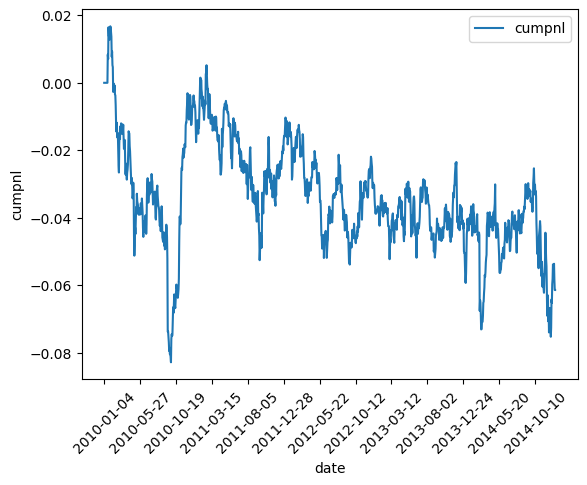

[-0.005393650259294827, -0.015776244220058903, -0.030270958681269822, -0.05037293629188285, -0.061358227341784664]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.099968,0.075045,0.099502,-0.005394
1,2011,-0.202965,0.063140,0.057725,-0.015776
2,2012,-0.363274,0.066375,0.043533,-0.030271
3,2013,-0.464552,0.059464,0.026906,-0.050373
4,2014,-0.202005,0.064519,0.049880,-0.061358


In [52]:
alpha_6_data, alpha_6_cumpnl = AlphaStats(alpha_6, close_df)
alpha_6_data.head()

In [53]:
test3(alpha_6_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [186]:
check_alpha_correlations(alphas, alpha_6_cumpnl)

mean_reverse:	-0.5113485326688711


## Alpha 7

((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1 * 1))

In [309]:
def average_dayly_volume(volume, day_step):
    adv = np.zeros_like(volume)

    for i in range(day_step, len(volume)):
        adv[i] = volume[i-day_step:i].mean(axis=0)

    return adv

In [298]:
def make_alpha_7(volume_df, close_df):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    
    adv = average_dayly_volume(volume, 20)

    close_delta = np.concatenate((np.zeros((7, close.shape[1])), close[7:] - close[:-7]))

    alpha = np.zeros_like(volume)
    for i in range(60, len(alpha)):
        alpha[i] = np.where(adv[i] < volume[i], -1 * ts_rank(np.abs(close_delta[i-60:i])) * np.sign(close_delta)[i], -1)      
                    

    return alpha
        

In [299]:
alpha_7 = make_alpha_7(volume_df, close_df)

KeyboardInterrupt: 

In [ ]:
_alpha_7 = neutralize(alpha_7)
_alpha_7 = normalize(_alpha_7)

test1(_alpha_7)
test2(_alpha_7[60:])

In [ ]:
alpha_7_data, alpha_7_cumpnl = AlphaStats(_alpha_7, close_df)
alpha_7_data.head()

In [64]:
test3(alpha_7_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [188]:
check_alpha_correlations(alphas, alpha_7_cumpnl)

mean_reverse:	0.8734274690304221


## Alpha 8

**(-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)), 10))))**

In [74]:
def make_alpha_8(open_df, close_df, sum_window=5, delay_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    
    return_matrix = instrument_return(close_df)

    open_sums = np.zeros(open.shape)
    returns_sums = np.zeros_like(return_matrix)
    for i in range(sum_window, len(open_sums)):
        open_sums[i] = open[i-sum_window:i].sum(axis=0)
        returns_sums[i] = return_matrix[i-sum_window:i].sum(axis=0)

    multy = returns_sums * open_sums

    alpha = np.zeros(open.shape)
    for i in range(delay_window, len(alpha)):
        alpha[i] = -1 * mpa.rank(multy[i] - multy[i-delay_window])

    return alpha

In [78]:
sum_step = 5
delay_step = 10

alpha_8 = make_alpha_8(open_df, close_df, sum_step, delay_step)

alpha_8 = neutralize(alpha_8)
alpha_8 = normalize(alpha_8)

test1(alpha_8)
test2(alpha_8[delay_step:])

Neutrality test passed
Normality test passed


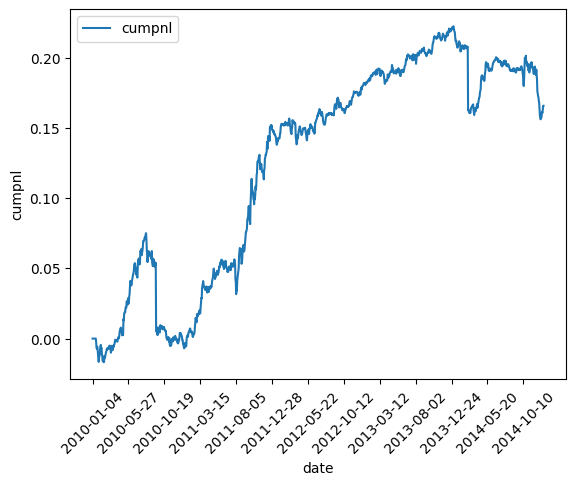

[-0.001134098145561627, 0.14870961281898507, 0.17978223421853148, 0.2211693315644873, 0.1659037122508854]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.018430,0.546528,0.080410,-0.001134
1,2011,3.118799,0.556526,0.024734,0.148710
2,2012,1.192493,0.551849,0.018421,0.179782
3,2013,1.940114,0.547307,0.010862,0.221169
4,2014,-1.005385,0.530429,0.066277,0.165904


In [79]:
alpha_8_data, alpha_8_cumpnl = AlphaStats(alpha_8, close_df)
alpha_8_data.head()

In [80]:
test3(alpha_8_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [189]:
check_alpha_correlations(alphas, alpha_8_cumpnl)

mean_reverse:	0.9512684386663794


## Alpha 9

**((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (-1 * delta(close, 1))))**

In [90]:
def ts_min(matrix):
    return np.min(matrix, axis=0)

In [92]:
def ts_max(matrix):
    return np.max(matrix, axis=0)

In [143]:
def make_alpha_9(close_df, min_max_window=10, delta_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _close = np.concatenate((np.zeros((1, close.shape[1])), close[delta_window:] - close[:-delta_window]))

    alpha = np.zeros_like(close)
    for i in range(min_max_window+1, len(alpha)):
        alpha[i] = np.where(ts_min(_close[i-1-min_max_window: i-1]) > 0, 
                            _close[i-1], 
                            np.where(ts_max(_close[i-1-min_max_window:i-1]) < 0, _close[i-1], -1 * close[i-1]))

    return alpha

In [144]:
min_max_window = 10
delta_window = 1

alpha_9 = make_alpha_9(close_df, min_max_window, delta_window)

alpha_9 = neutralize(alpha_9)
alpha_9 = normalize(alpha_9)

test1(alpha_9)
test2(alpha_9[min_max_window:])

Neutrality test passed
Normality test is not passed


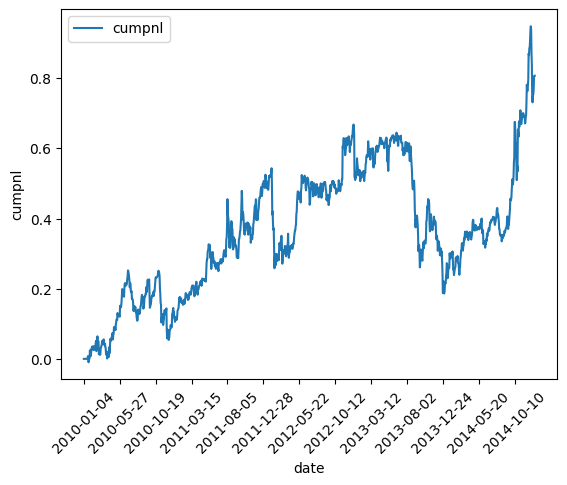

[0.133337461643025, 0.5072235662601874, 0.6678753345766038, 0.18655818776466587, 0.8077204343727433]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.654483,0.004030,0.198295,0.133337
1,2011,1.497462,0.000116,0.168209,0.507224
2,2012,0.590906,0.018125,0.285168,0.667875
3,2013,-1.607344,0.000216,0.481317,0.186558
4,2014,1.968197,0.000359,0.216875,0.807720


In [145]:
alpha_9_data, alpha_9_cumpnl = AlphaStats(alpha_9, close_df)
alpha_9_data.head()

In [146]:
test3(alpha_9_data)

Sharpe test not passed
Turnover test passed
Cumpnl test passed
passed 2 out of 3 tests


In [190]:
check_alpha_correlations(alphas, alpha_9_cumpnl)

mean_reverse:	0.7753719932513845


## Alpha 10

**rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : (-1 * delta(close, 1)))))**

In [148]:
def make_alpha_10(close_df, min_max_window=4, delta_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _close = np.concatenate((np.zeros((1, close.shape[1])), close[delta_window:] - close[:-delta_window]))

    sub_alpha = np.zeros_like(close)

    for i in range(min_max_window+1, len(sub_alpha)):
        sub_alpha[i] = mpa.rank(np.where(ts_min(_close[i-1-min_max_window:i-1]) > 0, 
                                _close[i-1], 
                                np.where(ts_max(_close[i-1-min_max_window: i-1])<0, _close[i-1], -1 * _close[i-1])))

    return sub_alpha

In [149]:
min_max_window = 4
delta_window = 1

alpha_10 = make_alpha_10(close_df, min_max_window, delta_window)

alpha_10 = neutralize(alpha_10)
alpha_10 = normalize(alpha_10)

test1(alpha_10)
test2(alpha_10[min_max_window:])

Neutrality test passed
Normality test is not passed


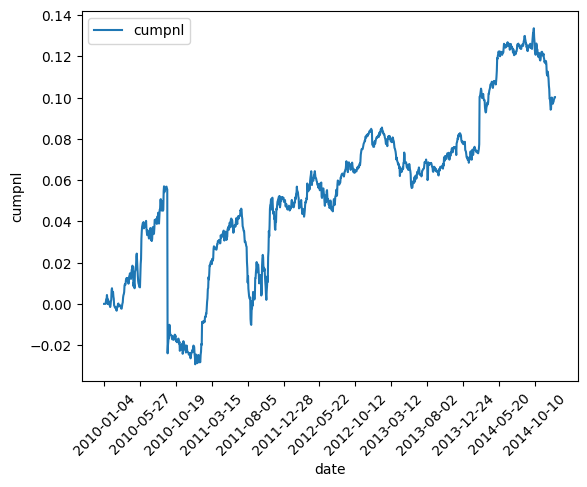

[-0.0208093925487973, 0.04945468706522463, 0.0761393688211244, 0.077395879489923, 0.10023871267312093]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.239922,1.235631,0.083396,-0.020809
1,2011,1.523260,1.264663,0.056368,0.049455
2,2012,0.990410,1.254243,0.019473,0.076139
3,2013,0.053618,1.257487,0.029340,0.077396
4,2014,0.692617,1.255143,0.039483,0.100239


In [150]:
alpha_10_data, alpha_10_cumpnl = AlphaStats(alpha_10, close_df)
alpha_10_data.head()

In [151]:
test3(alpha_10_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [191]:
check_alpha_correlations(alphas, alpha_10_cumpnl)

mean_reverse:	0.8924883759154326


## Alpha 11

**((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))**

## Alpha 12

**(sign(delta(volume, 1)) * (-1 * delta(close, 1)))**

In [162]:
def make_alpha_12(volume_df, close_df, delta_window):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)
    for i in range(delta_window+1, len(alpha)):
        alpha[i] = np.sign(volume[i-1] - volume[i-1-delta_window]) * (-1 * close[i-1] - close[i-1-delta_window])

    return alpha

In [173]:
delta_window  = 1

alpha_12 = make_alpha_12(volume_df, close_df, delta_window)

alpha_12 = neutralize(alpha_12)
alpha_12 = normalize(alpha_12)

test1(alpha_12)
test2(alpha_12[delta_window+1:])

Neutrality test passed
Normality test passed


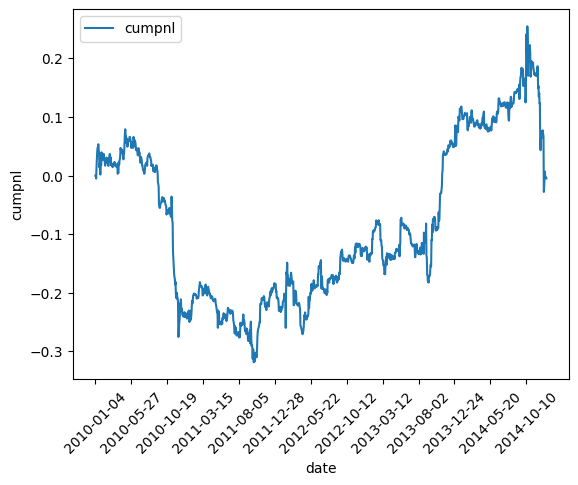

[-0.23550746911962475, -0.1848761918897723, -0.12340140011896913, 0.0506751545031163, -0.004798117080786417]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-1.596816,1.453379,0.354394,-0.235507
1,2011,0.427901,1.527351,0.136718,-0.184876
2,2012,0.406819,1.445123,0.122096,-0.123401
3,2013,1.070339,1.445802,0.110589,0.050675
4,2014,-0.239634,1.519845,0.282654,-0.004798


In [176]:
alpha_12_data, alpha_12_cumpnl = AlphaStats(alpha_12, close_df)
alpha_12_data.head()

In [165]:
test3(alpha_12_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [192]:
check_alpha_correlations(alphas, alpha_12_cumpnl)

mean_reverse:	0.2917036768845179


## Alpha 13

**(-1 * rank(covariance(rank(close), rank(volume), 5)))**

In [167]:
def covarience(vector1, vector2):
    return np.sum((vector1 - vector1.mean()) * (vector2 - vector2.mean()), axis=0)

In [170]:
def make_alpha_13(close_df, volume_df, cov_window):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)

    close_ranked = np.array([mpa.rank(_close) for _close in close])
    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])

    for i in range(cov_window+1, len(close)):
        alpha[i] = -1 * mpa.rank(covarience(close_ranked[i-1-cov_window:i-1], volume_ranked[i-1-cov_window:i-1]))

    return alpha

In [175]:
cov_window = 5

alpha_13 = make_alpha_13(close_df, volume_df, cov_window)

alpha_13 = neutralize(alpha_13)
alpha_13 = normalize(alpha_13)

test1(alpha_13)
test2(alpha_13[cov_window+1:])

Neutrality test passed
Normality test passed


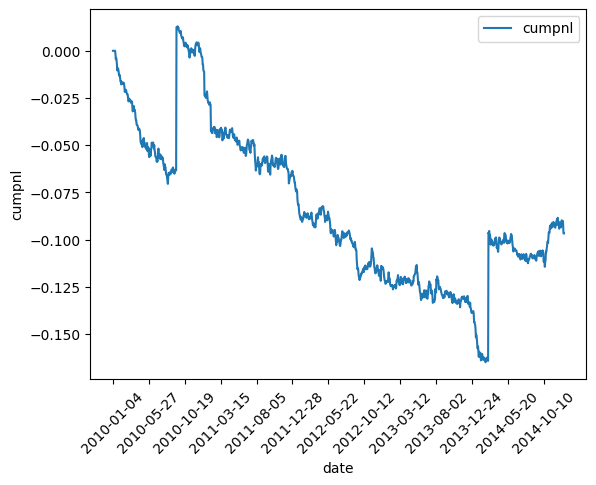

[-0.007380863190621352, -0.06603735151946581, -0.11461562460332769, -0.13782712733352953, -0.09668241040542913]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.092926,0.013104,0.070505,-0.007381
1,2011,-1.852965,0.009552,0.062824,-0.066037
2,2012,-2.054331,0.008214,0.055735,-0.114616
3,2013,-0.956508,0.007494,0.025274,-0.137827
4,2014,0.568469,0.007631,0.027067,-0.096682


In [177]:
alpha_13_data, alpha_13_cumpnl = AlphaStats(alpha_13, close_df)
alpha_13_data.head()

In [178]:
test3(alpha_13_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [193]:
check_alpha_correlations(alphas, alpha_13_cumpnl)

mean_reverse:	-0.8546658065209484


## Alpha 14

**((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))**

In [195]:
def make_alpha_14(close_df, open_df, volume_df, delta_window=3, cor_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    returns = instrument_return(close_df)

    alpha = np.zeros_like(close)
    for i in range(cor_window+1, len(alpha)):
        alpha[i] = -1 * mpa.rank(returns[i-1] - returns[i-1-delta_window]) * calc_alphas_corr(open[i-1-cor_window:i-1], 
                                                                                              volume[i-1-cor_window:i-1])

    return alpha

In [201]:
delta_window = 3
cor_window = 10

alpha_14 = make_alpha_14(close_df, open_df, volume_df, delta_window, cor_window)

alpha_14 = neutralize(alpha_14)
alpha_14 = normalize(alpha_14)

test1(alpha_14)
test2(alpha_14[cor_window+1:])

Neutrality test passed
Normality test passed


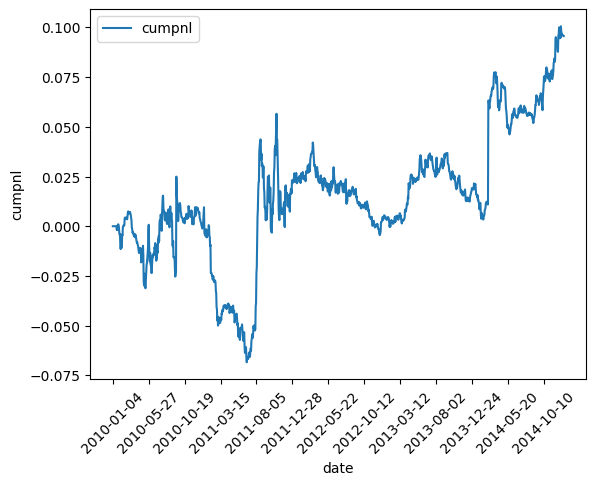

[-0.0008096765317783471, 0.021918364513649265, 0.004489141598519368, 0.01864675783601726, 0.09562502675293076]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.011947,1.245814,0.040714,-0.000810
1,2011,0.306565,1.304727,0.077988,0.021918
2,2012,-0.535587,1.286928,0.046506,0.004489
3,2013,0.530353,1.296258,0.024414,0.018647
4,2014,1.242091,1.299035,0.031311,0.095625


In [202]:
alpha_14_data, alpha_14_cumpnl = AlphaStats(alpha_14, close_df)
alpha_14_data.head()

In [203]:
test3(alpha_14_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [204]:
check_alpha_correlations(alphas, alpha_14_cumpnl)

mean_reverse:	0.6936446199446732


## Alpha 15

**-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3)**

In [214]:
def make_alpha_15(high_df, volume_df, cor_window=3, sum_window=3):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])
    high_ranked = np.array([mpa.rank(_high) for _high in high])

    ranked_high_volume = np.zeros_like(volume)
    for i in range(cor_window, len(ranked_high_volume)):
        ranked_high_volume[i] = mpa.rank(ts_correlation(high_ranked[i-cor_window:i], volume_ranked[i-cor_window:i]))

    alpha = np.zeros_like(volume)
    for i in range(max(sum_window, cor_window)+1, len(alpha)):
        alpha[i] = -1 * np.sum(ranked_high_volume[i - sum_window-1:i-1], axis=0)

    return alpha

In [222]:
cor_window = 3
sum_window = 3

alpha_15 = make_alpha_15(high_df, volume_df, cor_window, sum_window)

alpha_15 = neutralize(alpha_15)
alpha_15 = normalize(alpha_15)

test1(alpha_15)
test2(alpha_15[max(cor_window, sum_window)+2:])

Neutrality test passed
Normality test passed


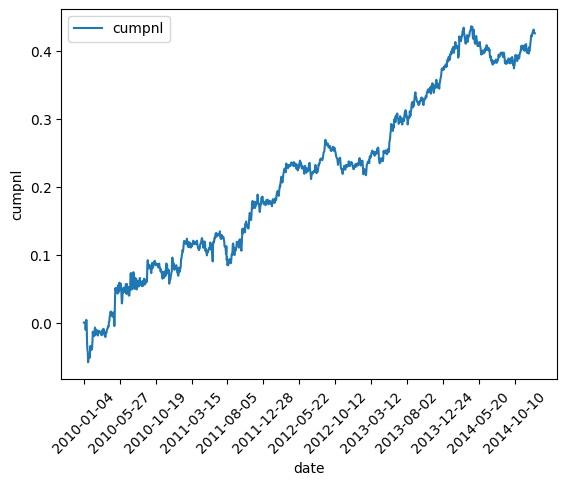

[0.08596026208747795, 0.17431013810514367, 0.2255269196547077, 0.3749800608876438, 0.42516647641281285]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.838514,0.186073,0.062374,0.085960
1,2011,1.113873,0.136954,0.049906,0.174310
2,2012,0.981899,0.145504,0.050166,0.225527
3,2013,2.314254,0.133759,0.025173,0.374980
4,2014,0.730279,0.123164,0.061981,0.425166


In [223]:
alpha_15_data, alpha_15_cumpnl = AlphaStats(alpha_15, close_df)
alpha_15_data.head()

In [224]:
test3(alpha_15_data)

Sharpe test not passed
Turnover test passed
Cumpnl test passed
passed 2 out of 3 tests


In [226]:
check_alpha_correlations(alphas, alpha_15_cumpnl)

mean_reverse:	0.9539031270926396


## Alpha 16

**(-1 * rank(covariance(rank(high), rank(volume), 5)))**

In [229]:
def make_alpha_16(high_df, volume_df, cov_window=5):
    
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])
    high_ranked = np.array([mpa.rank(_high) for _high in high])

    alpha = np.zeros_like(volume)
    for i in range(cov_window+1, len(alpha)):
        alpha[i] = -1 * mpa.rank(covarience(high_ranked[i-1-cov_window:i-1], volume_ranked[i-1-cov_window:i-1]))

    return alpha 

In [231]:
cov_window = 5

alpha_16 = make_alpha_16(high_df, volume_df, cov_window)

alpha_16 = neutralize(alpha_16)
alpha_16 = normalize(alpha_16)

test1(alpha_16)
test2(alpha_16[cov_window+1:])

Neutrality test passed
Normality test passed


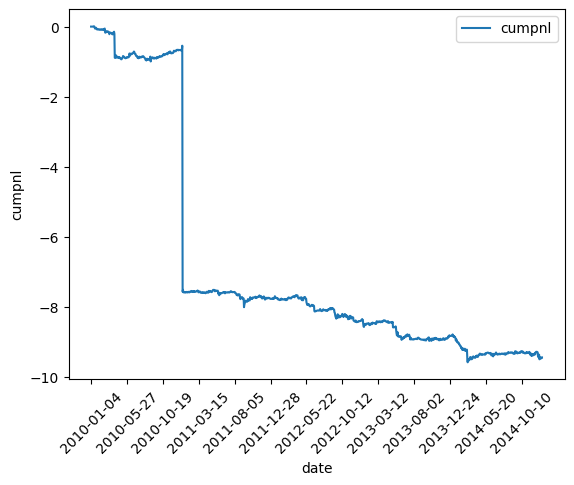

[-0.674682541612525, -7.7643282108471565, -8.390376433238798, -8.821485518286812, -9.435529365136619]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.883170,0.158794,1.003235,-0.674683
1,2011,-1.008752,0.215228,7.457648,-7.764328
2,2012,-1.547999,0.148061,0.773812,-8.390376
3,2013,-1.014651,0.138946,0.622394,-8.821486
4,2014,-1.248750,0.131006,0.795125,-9.435529


In [232]:
alpha_16_data, alpha_16_cumpnl = AlphaStats(alpha_16, close_df)
alpha_16_data.head()

In [233]:
test3(alpha_16_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [234]:
check_alpha_correlations(alphas, alpha_16_cumpnl)

mean_reverse:	-0.8595604032094543


## Alpha 17

**(((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) * rank(ts_rank((volume / adv20), 5)))**

In [316]:
def make_alpha_17(close_df, volume_df, ts_rank_close_window=10, delta_window=1, adv_window=20, ts_rank_volume_window=5):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    close_ranked = np.zeros_like(close)
    for i in range(ts_rank_close_window+1, len(close)):
        close_ranked[i] = mpa.rank(ts_rank(close[i - ts_rank_close_window - 1: i]))

    delta = np.zeros_like(close)
    for i in range(delta_window+1, len(delta)):
        delta[i] = close[i-1] - close[i-1-delta_window]

    delta_close = np.zeros_like(close)
    for i in range(delta_window, len(delta_close)):
        delta_close[i] = mpa.rank(delta[i] - delta[i-1])

    volume_adv = average_dayly_volume(volume, adv_window)
    volume_ranked = np.zeros_like(volume)
    for i in range(ts_rank_volume_window+1, len(volume)):
        volume_ranked[i] = mpa.rank(ts_rank(volume_adv[i-1-ts_rank_volume_window:i-1]))

    alpha = -1 * close_ranked * delta_close * volume_ranked
    return alpha

In [317]:
alpha_17 = make_alpha_17(close_df, volume_df)

In [320]:
alpha_17 = neutralize(alpha_17)
alpha_17 = normalize(alpha_17)

test1(alpha_17)
test2(alpha_17[11:])

Neutrality test passed
Normality test passed


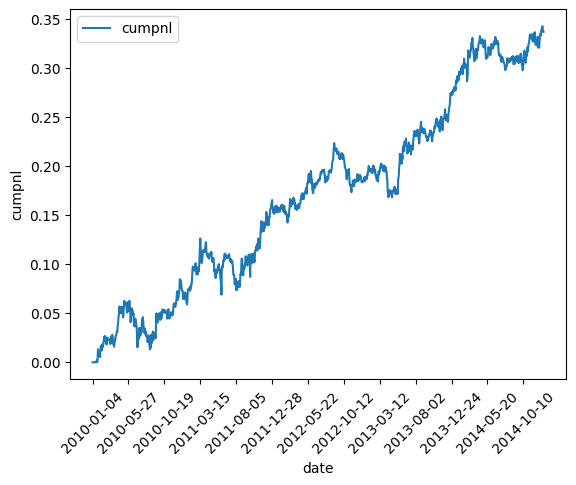

[0.0728590501340094, 0.15769303580576072, 0.18499064678291513, 0.2762335687169969, 0.33719055099054496]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.080608,3.968254e-03,0.049508,0.072859
1,2011,1.096908,1.654966e-16,0.057461,0.157693
2,2012,0.553636,1.782258e-16,0.050166,0.184991
3,2013,1.555362,1.816281e-16,0.034367,0.276234
4,2014,0.906031,1.775676e-16,0.034938,0.337191


In [321]:
alpha_17_data, alpha_17_cumpnl = AlphaStats(alpha_17, close_df)
alpha_17_data.head()

In [322]:
test3(alpha_17_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [323]:
check_alpha_correlations(alphas, alpha_17_cumpnl)

mean_reverse:	0.9489398071875415


## Alpha 18

**(-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open, 10))))**

In [327]:
def rolling_std(matrix):
    std_vector = np.zeros(matrix.shape[-1])
    for i in range(len(std_vector)):
        std_vector[i] = std(matrix.T[i])

    return std_vector

In [331]:
def make_alpha_18(close_df, open_df, std_window=5, corr_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    diff = close - open

    std_diff = np.zeros_like(close)
    for i in range(max(std_window, corr_window)+1, len(close)):
        std_diff[i] = rolling_std(np.abs(diff[i-1-std_window:i-1])) + diff[i-1]

    close_open_corr = np.zeros_like(close)
    for i in range(max(std_window, corr_window)+1, len(close)):
        close_open_corr[i] = ts_correlation(close[i-1-corr_window:i-1], open[i-1-corr_window:i-1])

    matrix = std_diff + close_open_corr
    alpha = np.zeros_like(close)
    for i in range(max(std_window, corr_window)+1, len(close)):
        alpha[i] = mpa.rank(alpha[i])

    return -1 * alpha

In [332]:
std_window=5
corr_window=10

alpha_18 = make_alpha_18(close_df, open_df, std_window, corr_window)

alpha_18 = neutralize(alpha_18)
alpha_18 = normalize(alpha_18)

test1(alpha_18)
test2(alpha_18[max(std_window, corr_window)+1:])

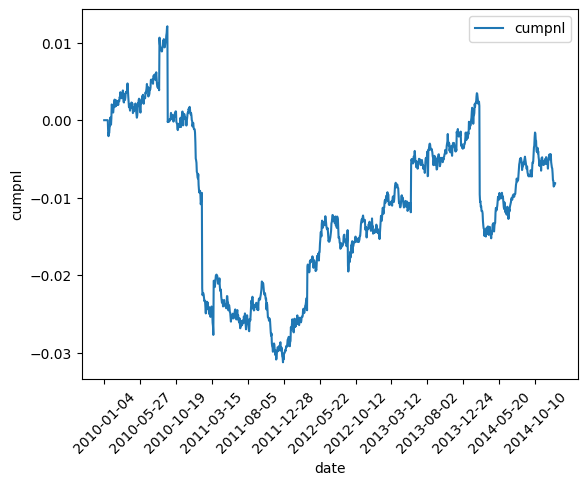

[-0.0011531492495136777, -0.03002501146852469, -0.01451023758048871, -0.0030420863055307702, -0.008115721902191023]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.071600,0.003968,0.013374,-0.001153
1,2011,-1.740895,0.000000,0.030034,-0.030025
2,2012,1.380855,0.000000,0.007283,-0.014510
3,2013,1.036144,0.000000,0.003799,-0.003042
4,2014,-0.363388,0.000000,0.018694,-0.008116


In [337]:
alpha_18_data, alpha_18_cumpnl = AlphaStats(alpha_18, close_df)
alpha_18_data.head()

In [338]:
test3(alpha_18_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [339]:
check_alpha_correlations(alphas, alpha_18_cumpnl)

mean_reverse:	-0.14348923706776892


## Alpha 19

**((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns, 250)))))**

In [343]:
def make_alpha_19(close_df, delta_window=7, sum_window=250):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    
    returns = instrument_return(close_prices=close)
    
    returns_ranked = np.zeros_like(close)
    for i in range(max(sum_window, delta_window)+1, len(close)):
        returns_ranked[i] = 1 + mpa.rank(1 + returns[i-sum_window-1:i-1].sum(axis=0))

    close_deltas = np.zeros_like(close)
    for i in range(max(sum_window, delta_window)+1, len(close)):
        close_deltas[i] = -1 * np.sign(close[i-1] - close[i-1-delta_window]) + (close[i-1] - close[i-1-delta_window])

    alpha = close_deltas * returns_ranked
    return alpha

In [345]:
delta_window = 7
sum_window = 250

alpha_19 = make_alpha_19(close_df, delta_window, sum_window)

alpha_19 = neutralize(alpha_19)
alpha_19 = normalize(alpha_19)

test1(alpha_19)
test2(alpha_19[max(delta_window, sum_window)+1:])

Neutrality test passed
Normality test passed


/Users/hubievkasym/Desktop/Sirius Uni/DerivativesControl/helper.py:177: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = len(alpha_pnl_vec)**0.5 * alpha_pnl_vec.mean() / std


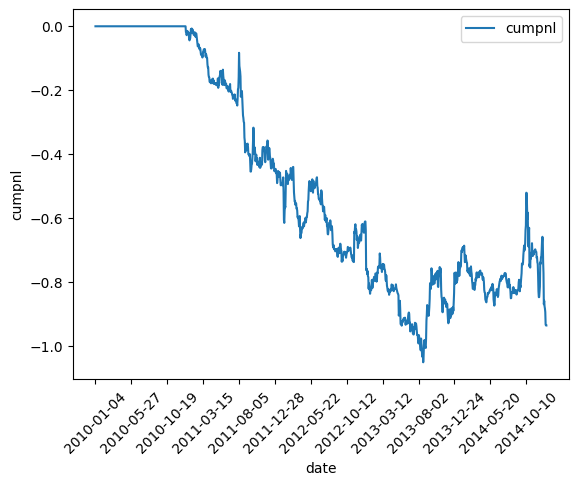

[0.0, -0.44562767652920476, -0.6096835114678232, -0.7692113645308774, -0.9344504020750659]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,NaN,0.003968,0.000000,0.000000
1,2011,-1.789571,0.335210,0.453874,-0.445628
2,2012,-0.607418,0.467364,0.297046,-0.609684
3,2013,-0.535419,0.471284,0.439711,-0.769211
4,2014,-0.514904,0.337079,0.414524,-0.934450


In [346]:
alpha_19_data, alpha_19_cumpnl = AlphaStats(alpha_19, close_df)
alpha_19_data.head()

In [347]:
test3(alpha_19_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [348]:
check_alpha_correlations(alphas, alpha_19_cumpnl)

mean_reverse:	-0.9505438729544365


## ALpha 20

**(((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open - delay(low, 1))))**

In [349]:
def make_alpha_20(open_df, close_df, high_df, low_df, delay_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)
    for i in range(delay_window+1, len(close)):
        alpha[i] = -1 * mpa.rank(open[i-1] - high[i-1-delay_window]) *\
                    mpa.rank(open[i-1] - close[i-1-delay_window]) *\
                    mpa.rank(open[i-1] - low[i-1-delay_window])

    return alpha    

In [350]:
delay_window = 1

alpha_20 = make_alpha_20(open_df, close_df, high_df, low_df, delay_window=1)

alpha_20 = neutralize(alpha_20)
alpha_20 = normalize(alpha_20)

test1(alpha_20)
test2(alpha_20[delay_window+1:])

Neutrality test passed
Normality test passed


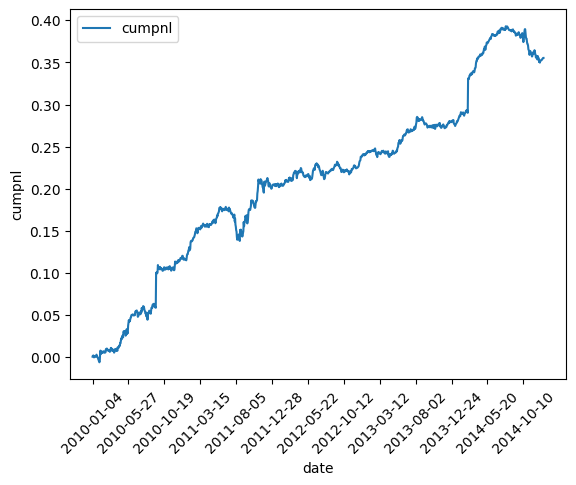

[0.12000313243815952, 0.2043301812054401, 0.23923029105499716, 0.2804153273041128, 0.3554406403358012]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.265932,1.251263,0.016177,0.120003
1,2011,1.908268,1.262094,0.040581,0.204330
2,2012,1.385219,1.278049,0.018877,0.239230
3,2013,1.819194,1.251721,0.014341,0.280415
4,2014,1.538730,1.270615,0.043265,0.355441


In [351]:
alpha_20_data, alpha_20_cumpnl = AlphaStats(alpha_20, close_df)
alpha_20_data.head()

In [352]:
test3(alpha_20_data)

Sharpe test passed
Turnover tets not passed
Cumpnl test passed
passed 2 out of 3 tests


In [353]:
check_alpha_correlations(alphas, alpha_20_cumpnl)

mean_reverse:	0.9646724779092919


## Alpha 21

**((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close, 2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume / adv20) == 1)) ? 1 : (-1 * 1))))**

## Alpha 22

**(-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))**

In [357]:
def make_alpha_22(close_df, high_df, volume_df, delta_window=5, corr_window=5, std_window=20):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    close_std = np.zeros_like(close)
    for i in range(max(delta_window, std_window)+1, len(close)):
        close_std[i] = mpa.rank(rolling_std(close[i-1-std_window:i-1]))

    corr_high_volume = np.zeros_like(close)
    for i in range(corr_window+1, len(close)):
        corr_high_volume[i] = ts_correlation(high[i-1-corr_window:i-1], volume[i-1-corr_window:i-1])

    alpha = np.zeros_like(close)
    for i in range(max(delta_window, std_window), len(close)):
        alpha[i] = -1 * (corr_high_volume[i] - corr_high_volume[i-delta_window]) * close_std[i]

    return alpha

In [358]:
delta_window=5
corr_window=5
std_window=20

alpha_22 = make_alpha_22(close_df, high_df, volume_df, delta_window, corr_window, std_window)

alpha_22 = neutralize(alpha_22)
alpha_22 = normalize(alpha_22)

test1(alpha_22)
test2(alpha_22[max(delta_window, std_window)+1:])

Neutrality test passed
Normality test passed


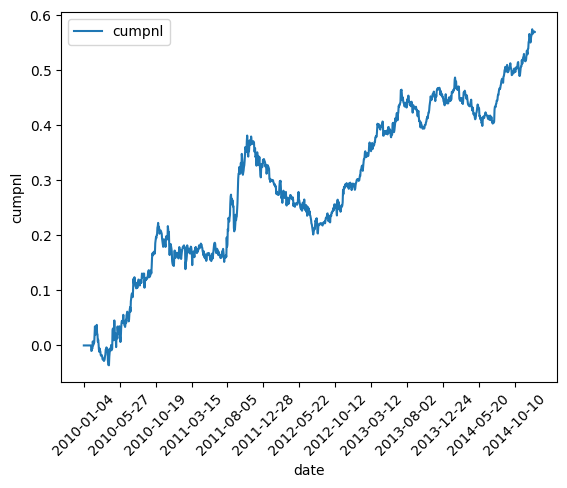

[0.14470372561526873, 0.33870858443935986, 0.29396023952912864, 0.44251016808823407, 0.5699062082773425]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.058734,0.909835,0.078138,0.144704
1,2011,1.329550,0.975973,0.076015,0.338709
2,2012,-0.455096,0.942962,0.136992,0.293960
3,2013,1.752918,1.030748,0.071061,0.442510
4,2014,1.545945,1.107195,0.087945,0.569906


In [359]:
alpha_22_data, alpha_22_cumpnl = AlphaStats(alpha_22, close_df)
alpha_22_data.head()

In [360]:
test3(alpha_20_data)

Sharpe test passed
Turnover tets not passed
Cumpnl test passed
passed 2 out of 3 tests


In [361]:
check_alpha_correlations(alphas, alpha_22_cumpnl)

mean_reverse:	0.9304342731752868


## Alpha 23

**(((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)**

In [385]:
def make_alpha_23(high_df, sum_window=20, delta_window=2):
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(high)
    for i in range(sum_window+1, len(high)):
        alpha[i] = np.where(high[i-1-sum_window:i-1].sum(axis=0) / 20 < high[i-1], -1 * (high[i-1] - high[i-1-delta_window]), 0)

    return alpha

In [388]:
sum_window = 20
delta_window = 2

alpha_23 = make_alpha_23(high_df, sum_window, delta_window)

alpha_23 = neutralize(alpha_23)
alpha_23 = normalize(alpha_23)

test1(alpha_23)
test2(alpha_23[sum_window+1:])

Neutrality test passed
Normality test passed


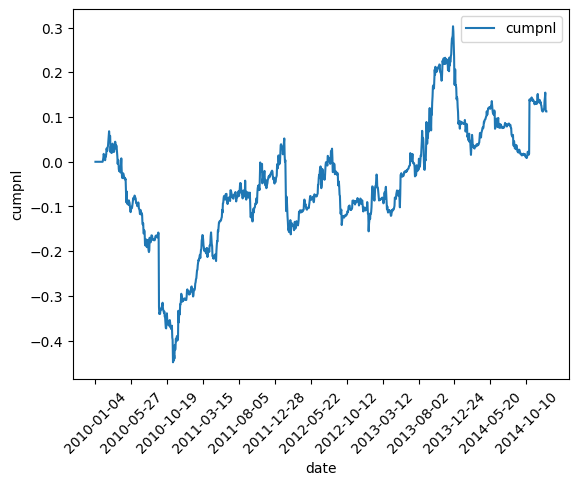

[-0.30875449186227, -0.04512323587229278, -0.10873723615072257, 0.17153074738066826, 0.11256277236405908]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-1.326714,0.783545,0.516583,-0.308754
1,2011,1.781049,0.998483,0.091107,-0.045123
2,2012,-0.362591,0.950865,0.214368,-0.108737
3,2013,1.274879,0.843254,0.131464,0.171531
4,2014,-0.346067,0.912983,0.162515,0.112563


In [389]:
alpha_23_data, alpha_23_cumpnl = AlphaStats(alpha_23, close_df)
alpha_23_data.head()

In [390]:
test3(alpha_23_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [391]:
check_alpha_correlations(alphas, alpha_23_cumpnl)

mean_reverse:	0.5954707107322952


## Alpha 24

**((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) || ((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close, 100))) : (-1 * delta(close, 3)))**

## ALpha 25

**rank(((((-1 * returns) * adv20) * vwap) * (high - close)))**

In [394]:
def make_alpha_25(close_df, high_df, adv_window):
    pass

## Alpha 26

**(-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))**

In [429]:
def make_alpha_26(volume_df, high_df, rank_window=5, corr_window=5, max_window=3):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.zeros_like(high)
    high_ranked = np.zeros_like(high)
    for i in range(rank_window, len(high)):
        volume_ranked[i] = ts_rank(volume[i-rank_window:i])
        high_ranked[i] = ts_rank(high[i-rank_window:i])

    corr_matrix = np.zeros_like(high)
    for i in range(corr_window, len(high)):
        if not np.array_equal(volume_ranked[i-corr_window:i], np.zeros_like(volume_ranked[i-corr_window:i])):
            corr_matrix[i] = ts_correlation(volume_ranked[i-corr_window:i], high_ranked[i-corr_window:i])


    alpha = np.zeros_like(high)
    for i in range(max(max_window, corr_window)+1, len(high)):
        alpha[i] = -1 * corr_matrix[i-1-max_window: i-1].max(axis=0)

    return alpha

In [434]:
rank_window=5
corr_window=5
max_window=3

alpha_26 = make_alpha_26(volume_df, high_df, rank_window, corr_window, max_window)

alpha_26 = neutralize(alpha_26)
alpha_26 = normalize(alpha_26)

test1(alpha_26)
test2(alpha_26[max(max_window, corr_window)+1:])

/Users/hubievkasym/Desktop/Sirius Uni/DerivativesControl/helper.py:380: RuntimeWarning: invalid value encountered in scalar divide
  corr = np.sum((alpha1 - alpha1.mean()) * (alpha2 - alpha2.mean()))/ (len(alpha1) - 1) / (std(alpha1) * std(alpha2))


Neutrality test passed
Normality test is not passed


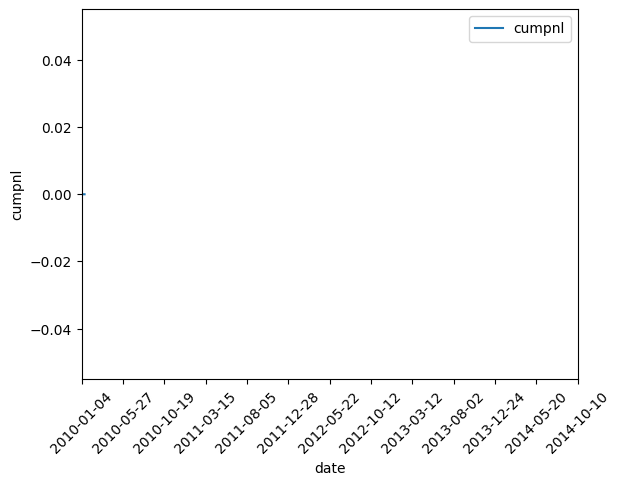

[nan, nan, nan, nan, nan]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,NaN,NaN,0.0,NaN
1,2011,NaN,NaN,0.0,NaN
2,2012,NaN,NaN,0.0,NaN
3,2013,NaN,NaN,0.0,NaN
4,2014,NaN,NaN,0.0,NaN


In [435]:
alpha_26_data, alpha_26_cumpnl = AlphaStats(alpha_26, close_df)
alpha_26_data.head()

In [436]:
test3(alpha_26_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


## Alpha 27

**((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)**

In [437]:
def make_alpha_27():
    pass

## Alpha 28

**scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))**

In [445]:
def scale(matrix, a):
    for i in range(len(matrix)):
        if np.abs(matrix[i]).sum() != 0:
            matrix[i] = matrix[i] * 2 / np.abs(matrix[i]).sum()
    return matrix

In [447]:
def make_alpha_28(high_df, low_df, close_df, volume_df, adv_window=20, corr_window=20, a=1):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    adv = average_dayly_volume(volume, adv_window)
    _alpha = np.zeros_like(close)
    for i in range(adv_window +corr_window+1, len(close)):
        _alpha[i] = ts_correlation(adv[i-1 - corr_window: i-1], low[i-1-corr_window: i-1]) +\
                                    (high[i-1] + low[i-1]) / 2 - close[i-1]

    
    return scale(_alpha, a)

In [449]:
adv_window=20
corr_window=5

alpha_28 = make_alpha_28(high_df, low_df, close_df, volume_df, adv_window, corr_window)

alpha_28 = neutralize(alpha_28)
alpha_28 = normalize(alpha_28)

test1(alpha_28)
test2(alpha_28[adv_window + corr_window+1:])

Neutrality test passed
Normality test passed


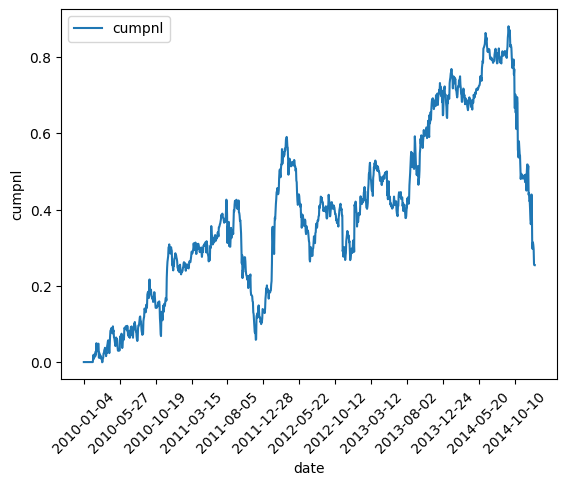

[0.2522313187428045, 0.13064124599743893, 0.3164176351741799, 0.7161957579268053, 0.25405091685290604]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.270554,0.921417,0.148417,0.252231
1,2011,-0.495435,0.873782,0.367488,0.130641
2,2012,0.692721,1.077892,0.326645,0.316418
3,2013,1.342090,1.051148,0.150912,0.716196
4,2014,-1.445516,0.977166,0.626491,0.254051


In [450]:
alpha_28_data, alpha_28_cumpnl = AlphaStats(alpha_28, close_df)
alpha_28_data.head()

In [451]:
test3(alpha_28_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [452]:
check_alpha_correlations(alphas, alpha_28_cumpnl)

mean_reverse:	0.8429488322153955


## Alpha 29

**min[product{rank(rank[scale{log[sum{ts_min[rank{rank(-1 * rank{delta[close - 1, 5]})}, 2], 1}]}]), 1}, 5] + ts_rank{delay[-1 * returns, 6], 5}**

In [ ]:
def make_alpha_29(close_df, returns_shift):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    returns = instrument_return(close_prices=close)

    returns_shifted = np.concatenate((np.zeros((returns_shift, close.shape[1])), returns[returns_shift:]))
    returns_ranked = np.zeros_like(close)